In [17]:
import re
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import pytensor.tensor.conv as ptconv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import arviz as az
import pandas as pd

# A) Model Defintions

in the next code cell the two models baseline and mmm are defined

In [8]:
CHANNEL_PRIORS = {
    "spend_channel_1": 0.05,
    "spend_channel_2": 0.05,
    "spend_channel_3": 0.05,
    "spend_channel_4": 0.05,
    "spend_channel_5": 0.05,
    "spend_channel_6": 0.05,
    "spend_channel_7": 0.05,
}


def scale(x, y):
    return x * y.sum() / x.sum()

def mean_normalize(data):
    return data / data.mean()

def create_baseline_mmm(media, channel_priors = CHANNEL_PRIORS):
    with pm.Model() as baseline_mmm:
        target = mean_normalize(media['revenue'])
        media_contributions = []
        for channel ,channel_prior in channel_priors.items():
             # define coefficient
            media_channel = pt.as_tensor_variable(media[channel])
            media_channel = mean_normalize(media_channel)
            scaled_channel = scale(media_channel, target)
            channel_coefficient = pm.TruncatedNormal(f"coefficient_{channel}", mu=channel_prior, sigma=0.1, lower=0, upper=0.5)
            channel_contribution = pm.Deterministic(f"contribution_{channel}", channel_coefficient * scaled_channel)
            media_contributions.append(channel_contribution)

        sigma = pm.Uniform("sigma", lower=0, upper=0.5)

        revenue = pm.Normal("revenue",
                    mu = sum(media_contributions),
                    sigma = sigma,
                    observed=target)
    
    return baseline_mmm

def logistic_curve(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

def cyclic_component(t, a0,a1,b1,period=20):
    return a0 + a1*np.cos(2*np.pi*t/period) + b1*np.sin(2*np.pi*t/period)

def _apply_delayed_adstock_tensor(data, weights):
    weights = weights[::-1]
    n_data = data.shape[0]
    n_weights = weights.shape[0]
    data = data.reshape((1, 1, 1, n_data) ) # Reshape for conv2d
    weights = weights.reshape((1, 1, 1, n_weights))  # Reshape for conv2d
    res = ptconv.conv2d(data, weights, border_mode='full')
    res = res.reshape((n_data + (n_weights - 1),))
    res = res[:n_data]
    return res

def black_friday(n, offset=13, period=52):
    res = np.zeros(n)
    for i in range(n):
        if i % period == offset:
            res[i] = 1
    return res

def create_mmm(media, channel_priors = CHANNEL_PRIORS):
    with pm.Model() as mmm:
        target = mean_normalize(media['revenue'])
        media_contributions = []
        for channel ,channel_prior in channel_priors.items():
             # define coefficient
            media_channel = pt.as_tensor_variable(media[channel])
            alpha = pm.Uniform(f"alpha_{channel}", lower=0.3, upper=0.9)
            L = 5 # fixed length
            theta = pm.DiscreteUniform(f"theta_{channel}", lower=0, upper=L-1)
            weights = pm.Deterministic(f'weights_{channel}',alpha ** ((pt.arange(L)) - theta) ** 2)
            media_transformed_channel = pm.Deterministic(f'media_transformed_{channel}', _apply_delayed_adstock_tensor(media_channel, weights))
            
            media_transformed_channel = mean_normalize(media_transformed_channel)
            scaled_channel = scale(media_transformed_channel, target) # Is this actually necessary?
            channel_coefficient = pm.TruncatedNormal(f"coefficient_{channel}", mu=channel_prior, sigma=0.1, lower=0, upper=0.5)
            channel_contribution = pm.Deterministic(f"contribution_{channel}", channel_coefficient * scaled_channel)
            media_contributions.append(channel_contribution)
        
        # trend component
        mean = target.mean()
        t = np.arange(len(target))
        t0 = t[len(target) // 2]
        capacity_coeff = pm.Normal("capacity_coef",mu=1.2, sigma=0.3)
        capacity = mean * capacity_coeff
        growth_rate = pm.TruncatedNormal("growth_rate", mu=-0.02, sigma=0.1, lower=-0.15, upper=0.0)
        trend = logistic_curve(t, capacity, growth_rate, t0)

        # cyclic year component

        cos_ceof = pm.Normal("cos_coef", mu=-1, sigma=0.3)
        sin_coef = pm.Normal("sin_coef", mu=2, sigma=0.3)
        BASE = 0
        period=52
        year = cyclic_component(t, BASE,cos_ceof,sin_coef,period=period)

        year_coeff = pm.Normal("year_coeff", mu=0.1, sigma=0.05)
        year = pm.Deterministic("year", year * year_coeff * mean)
        

        trend_year = pm.Deterministic("trend_year", trend + year)

        n = len(target)
        bf_index = black_friday(n)
        bf_coef = pm.Normal("black_friday_coef", mu=1, sigma=0.2)
        bf_contrib = pm.Deterministic("black_friday_contribution",bf_index*bf_coef*trend_year)
        trend_year += bf_contrib


        sigma = pm.Uniform("sigma", lower=0, upper=0.5)

        revenue = pm.Normal("revenue",
                    mu = trend_year  + sum(media_contributions),
                    sigma = sigma,
                    observed=target)
        
    return mmm

# B) Utilities and Experiments

In this code section utility functions as well as other experiment functions are defined

In [9]:
def prior_predictive(mmm):
    with mmm:
        prior_samples = pm.sample_prior_predictive(100)
    predicted = prior_samples.prior_predictive["revenue"].mean(axis=1)[0]
    return predicted

def posterior_predictive(mmm):
    with mmm:
        trace = pm.sample(tune=2000, idata_kwargs={"log_likelihood": True})
    
    posterior = pm.sample_posterior_predictive(trace, mmm)
    predictions = posterior['posterior_predictive']['revenue'].mean(axis=0).mean(axis=0)
    return trace, predictions

def load_media(path_to_data):
    media = pd.read_csv(path_to_data)
    media["start_of_week"] = pd.to_datetime(media["start_of_week"], format="%d-%m-%y")
    # 24-07-22
    media.sort_values(by="start_of_week", inplace=True)
    media.reset_index(drop=True, inplace=True)
    return media

def plot_media(media):
    return media.plot(x='start_of_week', title='MMM test data', legend=True)

def plot_predictions(media, predictions, title):
    observed = media['revenue'] / media['revenue'].mean()
    filename = title.replace(' ', '_')
    mse_str = ""
    for label, pred in predictions.items():
        mse = mean_squared_error(observed, pred)
        mse_str += f"  {label}={mse:.2f}"
    
    
    title = f'{title} (MSE: {mse_str})'
    plt.figure(figsize=(10, 6))
    observed = media['revenue'] / media['revenue'].mean()
    plt.plot(observed, label='Observed')

    for label, pred in predictions.items():
        plt.plot(pred, label=label)

    dates = media['start_of_week']
    plt.xticks(np.arange(0, len(dates), 10), dates.dt.date[::10], rotation=45)
    plt.title(title)    
    plt.legend()

    plt.savefig(f'report/img/{filename}.png')
    plt.show()

def calc_channel_contribution(summary, media):
    mean_vals = summary['mean']
    contribution = mean_vals[mean_vals.index.str.contains('contribution_spend_channel_')]

    def extract_channel_number(col_name):
        match = re.search(r'_(\d+)\[', col_name)
        if match:
            return match.group(1)
        return None


    channel_numbers = [extract_channel_number(i) for i in contribution.index]
    values = pd.DataFrame(index=contribution.index, data=contribution.values, columns=['contribution (%)'])
    values['channel'] = channel_numbers

    # group by channel and sum the contributions
    channel_contributions = values.groupby('channel').mean()
    channel_contributions = channel_contributions.sort_values(by='contribution (%)', ascending=False)
    channel_contributions['contribution (abs)'] = channel_contributions['contribution (%)'] * media['revenue'].sum()
    channel_contributions['spending'] = channel_contributions.index.map(lambda i: media[f'spend_channel_{i}'].sum())

    # calculate ROI 

    channel_contributions['ROI'] = channel_contributions['contribution (abs)'] / channel_contributions['spending']

    return channel_contributions


def plot_roi_contribution(df, title='Channel Contribution and ROI'):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    int_index = df.index.astype(int)

    contribution_color = '#87CEFA'  # Light Sky Blue
    roi_color = '#90EE90'

    # Bar chart for absolute contributions
    bar_width = 0.24
    width = 0.2
    ax1.bar(int_index - bar_width/2, df['contribution (%)'], width=width, color=contribution_color, align='center', label='Contribution (%)')
    ax1.set_xlabel('Channel')
    ax1.set_ylabel('Contribution (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for ROI
    ax2 = ax1.twinx()
    ax2.bar(int_index + bar_width/2, df['ROI'], width=width, color=roi_color, align='center', label='ROI')
    ax2.set_ylabel('ROI', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Title and layout adjustments
    plt.title(title)
    fig.tight_layout()

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # save the plot
    filename = title.replace(' ', '_')
    plt.savefig(f'report/img/{filename}.png')
    # Show plot
    plt.show()

# C) Runtime Experiments

Execution of the code and results

<Axes: title={'center': 'MMM test data'}, xlabel='start_of_week'>

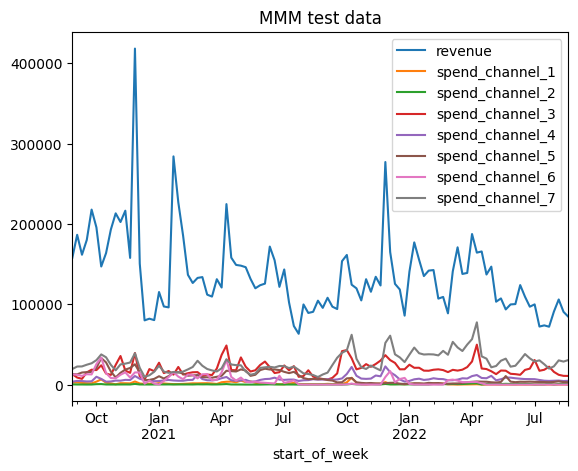

In [11]:
path_to_data = 'data/MMM_test_data.csv'
media = load_media(path_to_data)
plot_media(media)

In [12]:
baseline = create_baseline_mmm(media)
baseline_prior_prediction = prior_predictive(baseline)
mmm = create_mmm(media)
mmm_prior_prediction = prior_predictive(mmm)

predichtion_data = {
    "baseline": baseline_prior_prediction,
    "mmm": mmm_prior_prediction
}

Sampling: [coefficient_spend_channel_1, coefficient_spend_channel_2, coefficient_spend_channel_3, coefficient_spend_channel_4, coefficient_spend_channel_5, coefficient_spend_channel_6, coefficient_spend_channel_7, revenue, sigma]
Sampling: [alpha_spend_channel_1, alpha_spend_channel_2, alpha_spend_channel_3, alpha_spend_channel_4, alpha_spend_channel_5, alpha_spend_channel_6, alpha_spend_channel_7, black_friday_coef, capacity_coef, coefficient_spend_channel_1, coefficient_spend_channel_2, coefficient_spend_channel_3, coefficient_spend_channel_4, coefficient_spend_channel_5, coefficient_spend_channel_6, coefficient_spend_channel_7, cos_coef, growth_rate, revenue, sigma, sin_coef, theta_spend_channel_1, theta_spend_channel_2, theta_spend_channel_3, theta_spend_channel_4, theta_spend_channel_5, theta_spend_channel_6, theta_spend_channel_7, year_coeff]


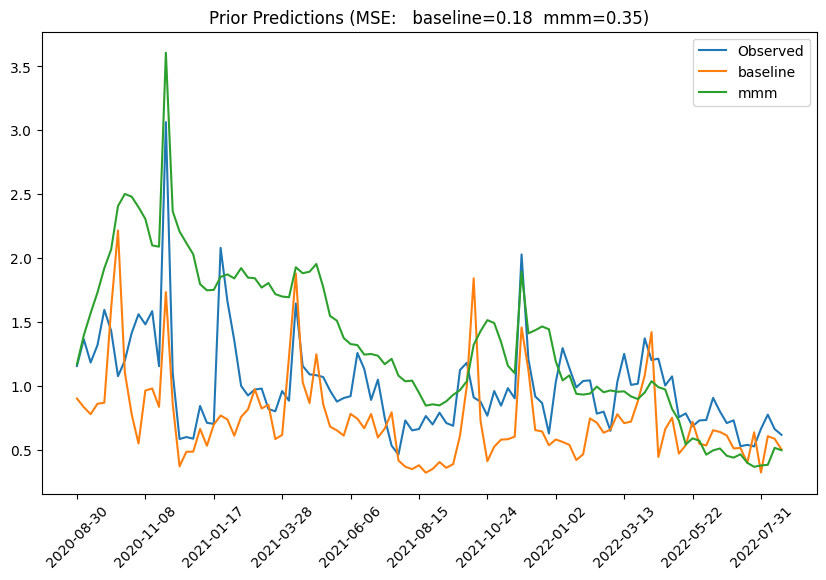

In [13]:
plot_predictions(media, predichtion_data, title="Prior Predictions")

In [14]:
baseline_trace, baseline_posterior_predictions = posterior_predictive(baseline)
mmm_trace, mmm_posterior_predictions = posterior_predictive(mmm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefficient_spend_channel_1, coefficient_spend_channel_2, coefficient_spend_channel_3, coefficient_spend_channel_4, coefficient_spend_channel_5, coefficient_spend_channel_6, coefficient_spend_channel_7, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.
Sampling: [revenue]


Output()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_spend_channel_1, coefficient_spend_channel_1, alpha_spend_channel_2, coefficient_spend_channel_2, alpha_spend_channel_3, coefficient_spend_channel_3, alpha_spend_channel_4, coefficient_spend_channel_4, alpha_spend_channel_5, coefficient_spend_channel_5, alpha_spend_channel_6, coefficient_spend_channel_6, alpha_spend_channel_7, coefficient_spend_channel_7, capacity_coef, growth_rate, cos_coef, sin_coef, year_coeff, black_friday_coef, sigma]
>CompoundStep
>>Metropolis: [theta_spend_channel_1]
>>Metropolis: [theta_spend_channel_2]
>>Metropolis: [theta_spend_channel_3]
>>Metropolis: [theta_spend_channel_4]
>>Metropolis: [theta_spend_channel_5]
>>Metropolis: [theta_spend_channel_6]
>>Metropolis: [theta_spend_channel_7]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [revenue]


Output()

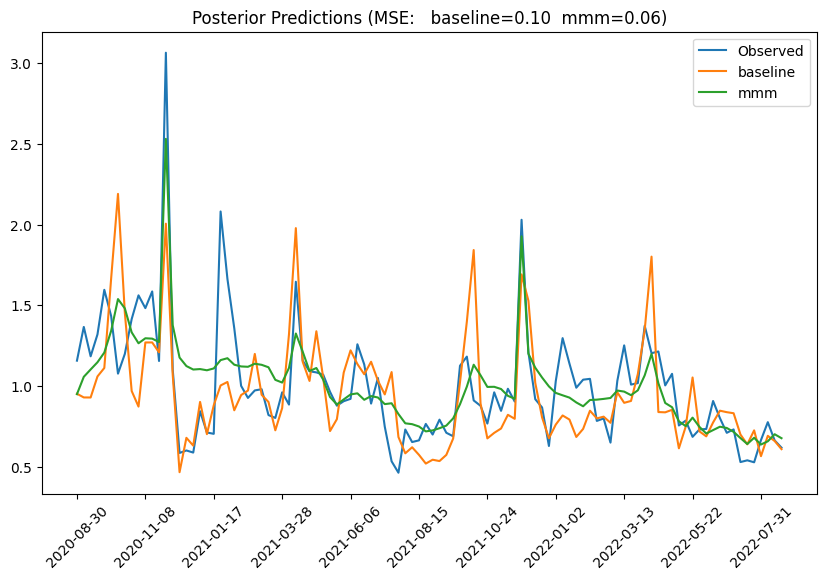

In [15]:
posterior_prediction_data = {
    "baseline": baseline_posterior_predictions,
    "mmm": mmm_posterior_predictions
}
plot_predictions(media, posterior_prediction_data, f'Posterior Predictions')

In [18]:
df_comp_loo = az.compare({"baseline": baseline_trace, "mmm": mmm_trace})
df_comp_loo.head()

/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mmm,0,-7.973558,10.952995,0.000000,0.882398,10.389309,0.000000,False,log
baseline,1,-34.588133,10.226999,26.614574,0.117602,13.164045,10.326976,True,log


/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/pmengers/Documents/private/haensel-ams/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_s

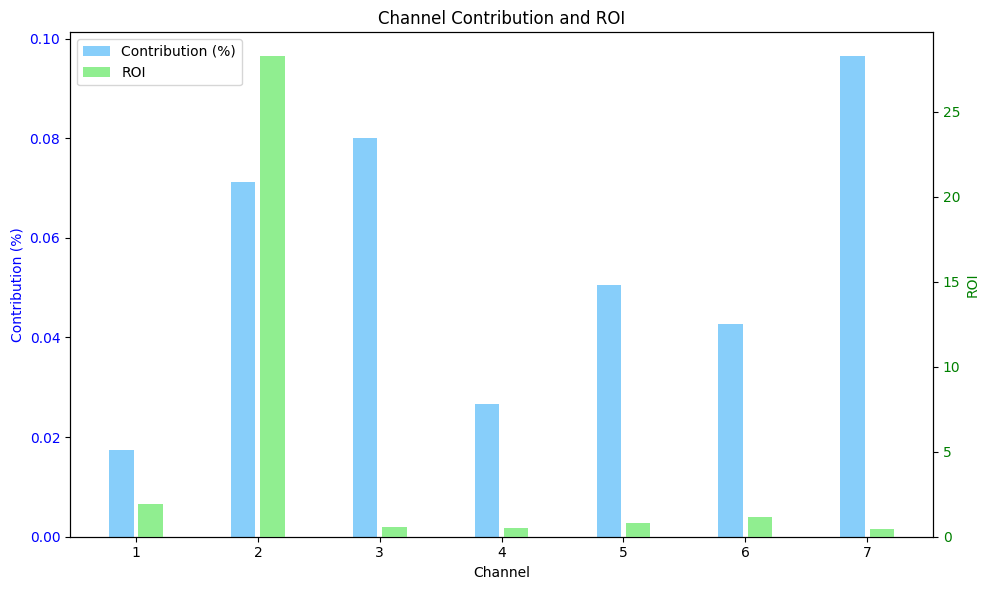

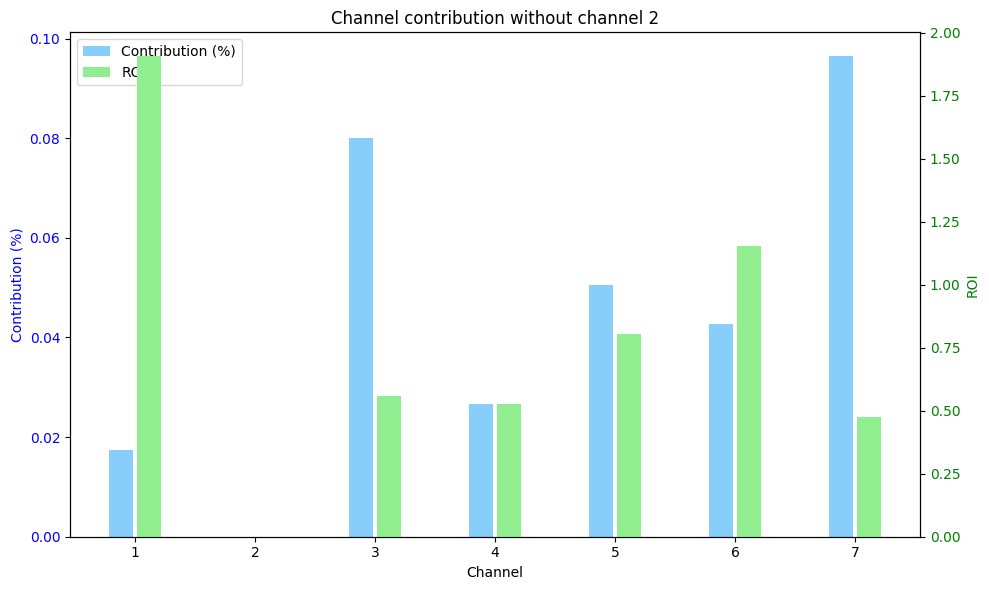

In [19]:
summary = az.summary(mmm_trace, round_to=2)
channel_contributions = calc_channel_contribution(summary, media)
plot_roi_contribution(channel_contributions)
channel_contributions_2 = channel_contributions.drop('2')
plot_roi_contribution(channel_contributions_2, title='Channel contribution without channel 2')